In [1]:
!aws s3 cp s3://tc-radare2-training-data/radare2_train.jsonl .


download: s3://tc-radare2-training-data/radare2_train.jsonl to ./radare2_train.jsonl


In [2]:
%env TOKENIZERS_PARALLELISM=0


env: TOKENIZERS_PARALLELISM=0


In [2]:

import datasets
dataset = datasets.load_dataset("json", data_files="radare2_train.jsonl", split="train")



Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
import datasets

items = []
for index, item in enumerate(dataset):
  if index >= 36160:    
    for i in range(25):
      items.append({
        "messages": [
          {"role": "system", "content": "You are an expert reverse engineer, proficient in radare2."},
          {"role": "user", "content": item['messages'][1]['content']},
          {"role": "assistant", "content": item["messages"][2]["content"]}
        ]
      })
  else:
    items.append({ "messages": [
      {"role": item['messages'][0]['role'], "content": item['messages'][0]['content']},
      {"role": item['messages'][1]['role'], "content": item['messages'][1]['content']},
      {"role": item['messages'][2]['role'], "content": item['messages'][2]['content']}
    ] })
combined = datasets.Dataset.from_list(items)
combined = combined.shuffle(seed=42)
combined.save_to_disk('r2_dataset')
dataset = combined

# good_dataset = datasets.Dataset.from_list(items)
# good_dataset = good_dataset.shuffle(seed=42)
# items = []
# for item in dataset:
#   messages = []
#   for m in item['messages']:
#     messages.append({"role": m['role'], "content": m['content']})
#   items.append({"messages": messages})

# for item in good_dataset:
#   messages = []
#   for m in item['messages']:
#     messages.append({"role": m['role'], "content": m['content']})
#   items.append({"messages": messages})
  
# both_dataset = datasets.Dataset.from_list(items)
# both_dataset.save_to_disk('r2_dataset')


Saving the dataset (0/1 shards):   0%|          | 0/45285 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer
import datasets
dataset = datasets.load_from_disk('r2_dataset')
# print the first 10 examples
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

print(dataset)
for i in range(10):
  print(tokenizer.apply_chat_template(dataset[i]['messages'], tokenize=False))


In [4]:

from huggingface_hub import interpreter_login

interpreter_login()



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



In [5]:

import datasets
from datasets import load_dataset
import random
tech_dataset = datasets.load_dataset("teknium/openhermes")

# Random sample 6k
random_indices = random.sample(range(len(tech_dataset['train'])), 6000)
tech_sample = tech_dataset['train'].select(random_indices)

# Convert OpenHermes format to match the existing dataset structure
def convert_openhermes_format(example):
    return {
        'messages': [
            {"role": "user", "content": example['instruction']},
            {"role": "assistant", "content": example['output']}
        ]
    }

# Convert format
tech_sample = tech_sample.map(convert_openhermes_format)

# Ensure the structure matches between datasets
def restructure_messages(example):
    return {
        'messages': [
            {
                "role": message["role"],
                "content": message["content"]
            }
            for message in example['messages']
        ]
    }

# Apply restructuring to both datasets
combined = []
for d in dataset: 
  combined.append(restructure_messages(d))
for d in tech_sample: 
  combined.append(restructure_messages(d))
print(len(combined), len(dataset), len(tech_sample))

combined_dataset = datasets.Dataset.from_list(combined)
# Shuffle the combined dataset
combined_shuffled = combined_dataset.shuffle(seed=42)

# Save the combined dataset
combined_shuffled.save_to_disk('r2_dataset_hermes')

README.md:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

openhermes.json:   0%|          | 0.00/328M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/242831 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

51285 45285 6000


Saving the dataset (0/1 shards):   0%|          | 0/51285 [00:00<?, ? examples/s]

In [15]:
datasets.load_from_disk('r2_dataset_hermes')
#datasets.load_from_disk('r2_dataset')


Dataset({
    features: ['messages'],
    num_rows: 42525
})

In [ ]:
%load_ext tenasorboard
%tensorboard --logdir logs


In [7]:

import random
import torch
import logging
import datasets
import torch.distributed as dist
from datasets import load_dataset, concatenate_datasets, DatasetDict, load_from_disk
from peft import LoraConfig, get_peft_model, PeftModel
import transformers
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    AutoModel
)
import os
from trl import DataCollatorForCompletionOnlyLM, SFTConfig, SFTTrainer, setup_chat_format
from accelerate import PartialState
from accelerate import Accelerator, notebook_launcher
from transformers import pipeline

def generate_response(model, tokenizer, messages, device="cuda"):
    """Generate a response from the model based on an instruction."""
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
    return pipe(messages, max_new_tokens=128)[0]['generated_text'][-1]
class CustomCallback(transformers.TrainerCallback):
    def __init__(self, model, tokenizer, accelerator):
        self.model = model
        self.tokenizer = tokenizer
        self.eval_examples = [
            [
                {"role": "system", "content": "You are an expert reverse engineer, proficient in radare2."},
                {"role": "user", "content": "How do I list basic blocks in radare2?"}
            ],
            [
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": "What is recursion in programming?"}
            ],
            [
                {"role": "system", "content": "You are an expert reverse engineer, proficient in radare2."},
                {"role": "user", "content": "How do I view strings in a binary?"}
            ]
        ]
        self.accelerator = accelerator
        
    def on_epoch_end(self, args, state, control, **kwargs):
        # Only run on main process with accelerate
        if self.accelerator.is_main_process:
            print("\n=== Custom Evaluation Examples ===")
            for messages in self.eval_examples:
                print(f"\nPrompt: {messages[1]['content']}")
                try:
                    response = generate_response(self.model, self.tokenizer, messages)
                    print(f"Response: {response}\n")
                except Exception as e:
                    print(f"Error generating response: {e}")
                print("-" * 50)
def train():
    # Load dataset and model
   # Load and split dataset
    dataset = load_from_disk('r2_dataset_hermes')
    
    train_dataset, eval_dataset = dataset.train_test_split(
        test_size=0.1,
        seed=42  # Added for reproducibility
    ).values() 


    model_name = "HuggingFaceTB/SmolLM2-135M-Instruct"
    output_dir = f"SmolLM2-135M-r2ai"

    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO
    )

    
    print(f"Train samples: {len(train_dataset)}, Eval samples: {len(eval_dataset)}")
    # Calculate optimal training parameters
    num_training_samples = len(train_dataset)
    num_gpus = 4
    per_device_batch_size = 16  # Reduced from 32
    total_batch_size = per_device_batch_size * num_gpus
    grad_accum_steps = 2  # Reduced from 4
    effective_batch_size = total_batch_size * grad_accum_steps
    num_epochs = 100
    num_training_steps = (num_training_samples * num_epochs) // effective_batch_size
    
    # Accelerator setup
    accelerator = Accelerator(
        gradient_accumulation_steps=grad_accum_steps,
        mixed_precision="bf16",
        log_with="tensorboard",
        project_dir="logs"
    )
    
    if accelerator.is_local_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()
    # LoRA configuration with target modules
    peft_config = LoraConfig(
        r=32,
        lora_alpha=64,
        lora_dropout=0,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
        inference_mode=False,
    )
    def formatting_prompts_func(example: dict) -> str:
        """Format prompt for training."""
        text = f"<|im_start|>system\n{example['messages'][0]['content']}<|im_end|><|im_start|>user\n{example['messages'][1]['content']}<|im_end|>\n<|im_start|>assistant\n{example['messages'][2]['content']}<|im_end|>"
        return text

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map={'':accelerator.process_index},
        torch_dtype=torch.bfloat16,
        use_cache=False,
    )
    # model, tokenizer = setup_chat_format(model, tokenizer)
    # for name, param in model.base_model.named_parameters():
    #     param.requires_grad = False
    model = get_peft_model(model, peft_config)
    # model.enable_input_requires_grad()
    # for name, param in model.named_parameters():
    #     param.requires_grad = True


    if accelerator.is_local_main_process:
        print(f"Number of training samples: {num_training_samples}")
        print(f"Number of epochs: {num_epochs}")
        print(f"Per device batch size: {per_device_batch_size}")
        print(f"Gradient accumulation steps: {grad_accum_steps}")
        print(f"Total batch size: {effective_batch_size}")
        print(f"Total optimization steps: {num_training_steps}")
        model.print_trainable_parameters()

    # Training configuration
    sft_config = SFTConfig(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        # max_steps=num_training_steps,
        max_seq_length=768,
        per_device_train_batch_size=per_device_batch_size,
        gradient_accumulation_steps=grad_accum_steps,
        gradient_checkpointing=False,
        optim="paged_adamw_32bit",
        save_steps=300,
        logging_steps=10,
        logging_strategy="steps",
        learning_rate=0.0005,
        weight_decay=0.0001,
        bf16=True,
        warmup_ratio=0.05,
        lr_scheduler_type="cosine",
        packing=True,
        ddp_find_unused_parameters=False,
        eval_strategy="epoch",
        # eval_steps=max(num_training_steps // 20, 1),  # Evaluate 20 times during training
        logging_first_step=True,
        # load_best_model_at_end=True,
        # metric_for_best_model="eval_loss",
        remove_unused_columns=False,
        group_by_length=True,
        
    )

    # Initialize trainer
    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        # formatting_func=formatting_prompts_func,
        args=sft_config,
        callbacks=[CustomCallback(model, tokenizer, accelerator)]
        
    )

    # Train and evaluate
    train_result = trainer.train()
    metrics = train_result.metrics
    trainer.save_model(output_dir)
    trainer.log_metrics("train", metrics)

    # Final evaluation
    eval_metrics = trainer.evaluate()
    trainer.log_metrics("eval", eval_metrics)

notebook_launcher(train, num_processes=4)




Launching training on 4 GPUs.
Train samples: 46156, Eval samples: 5129
Train samples: 46156, Eval samples: 5129
Train samples: 46156, Eval samples: 5129
Train samples: 46156, Eval samples: 5129


loading file vocab.json from cache at /home/ubuntu/.cache/huggingface/hub/models--HuggingFaceTB--SmolLM2-135M-Instruct/snapshots/7e27bd9f95328f0f3b08261d1252705110c806f8/vocab.json
loading file merges.txt from cache at /home/ubuntu/.cache/huggingface/hub/models--HuggingFaceTB--SmolLM2-135M-Instruct/snapshots/7e27bd9f95328f0f3b08261d1252705110c806f8/merges.txt
loading file tokenizer.json from cache at /home/ubuntu/.cache/huggingface/hub/models--HuggingFaceTB--SmolLM2-135M-Instruct/snapshots/7e27bd9f95328f0f3b08261d1252705110c806f8/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /home/ubuntu/.cache/huggingface/hub/models--HuggingFaceTB--SmolLM2-135M-Instruct/snapshots/7e27bd9f95328f0f3b08261d1252705110c806f8/special_tokens_map.json
loading file tokenizer_config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--HuggingFaceTB--SmolLM2-135M-Instruct/snapshots/7e27bd9f95328f0f3b08261d1252705110c806f8/tokenizer_c

Number of training samples: 46156
Number of epochs: 100
Per device batch size: 16
Gradient accumulation steps: 2
Total batch size: 128
Total optimization steps: 36059
trainable params: 3,686,400 || all params: 138,201,408 || trainable%: 2.6674


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
11/04/2024 13:03:23 - INFO - Formatting dataset with chatml format


Generating train split: 0 examples [00:00, ? examples/s]

11/04/2024 13:03:23 - INFO - Formatting dataset with chatml format
11/04/2024 13:03:23 - INFO - Formatting dataset with chatml format
11/04/2024 13:03:23 - INFO - Formatting dataset with chatml format
[rank2]:[W1104 13:03:23.613081682 ProcessGroupNCCL.cpp:4115] [PG ID 0 PG GUID 0 Rank 2]  using GPU 2 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device,or call init_process_group() with a device_id.
[rank3]:[W1104 13:03:23.624353464 ProcessGroupNCCL.cpp:4115] [PG ID 0 PG GUID 0 Rank 3]  using GPU 3 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device,or call init_process_group() with a device_id.
[rank1]:[W1104 13:03:23.629782361 ProcessGroupNCCL.cpp:4115] [PG ID 0

Epoch,Training Loss,Validation Loss
0,1.780000,1.721320
2,1.362600,1.348298
4,1.198000,1.185613
6,1.034800,1.040164
8,0.921300,0.945929
10,0.869600,0.904068
12,0.844900,0.891724


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



=== Custom Evaluation Examples ===

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Prompt: How do I list basic blocks in radare2?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "To list basic blocks in radare2, you can use the `list` function. Here's an example:\n\n```\nprint(list(radare2.basic_blocks))\n```\n\nThis will print a list of all the basic blocks in radare2.\n\nAlternatively, you can use the `list` function with a list comprehension:\n\n```\nprint(list(radare2.basic_blocks, list(radare2.basic_blocks)))\n```\n\nThis will print a list of all the basic blocks in radare2, along with their names.\n\nNote"}

--------------------------------------------------

Prompt: What is recursion in programming?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': 'Recursion is a programming technique where a function calls itself repeatedly until it reaches a base case that stops the recursion. This allows the function to solve a problem by breaking it down into smaller instances of the same problem, which can be solved by the same function.\n\nIn other words, a recursive function calls itself with a smaller input until it reaches a base case that stops the recursion. This allows the function to solve the problem by breaking it down into smaller instances of the same problem, which can be solved by the same function.\n\nRecursion is a powerful technique in programming, as it allows for the creation'}

--------------------------------------------------

Prompt: How do I view strings in a binary?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "To view strings in a binary, you can use the `str.decode()` method. Here's an example:\n\n```python\nimport numpy as np\n\n# Create a numpy array\narr = np.array([1, 2, 3])\n\n# Convert the array to a binary\nbinary_arr = arr.decode()\n\n# Print the binary\nprint(binary_arr)\n```\n\nThis will output:\n\n```\n1 2 3\n```\n\nAlternatively, you can use the `bin()` function to convert the array to a binary:\n\n```python"}

--------------------------------------------------


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 799
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



=== Custom Evaluation Examples ===

Prompt: How do I list basic blocks in radare2?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': '\nThis command lists the basic blocks in radare2, which are the basic blocks of a program.\n\n```\nb\n```'}

--------------------------------------------------

Prompt: What is recursion in programming?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': 'Recursion is a programming technique where a function calls itself to solve a problem. It is a fundamental concept in programming that allows a function to be repeated multiple times, often with the same inputs, to solve a problem.\n\nIn recursion, a function calls itself with a smaller input, which is the base case, and then recursively calls itself with the larger input. This process continues until the base case is reached, at which point the recursion stops and the function solves the problem.\n\nRecursion is useful for solving problems that have a recursive structure, such as tree traversals, recursive algorithms, and data'}

--------------------------------------------------

Prompt: How do I view strings in a binary?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': '\nThis command allows you to view strings in a binary, which is useful for debugging and analyzing binary data.\n\n```\n/s\n```'}

--------------------------------------------------


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 799
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



=== Custom Evaluation Examples ===

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.




Prompt: How do I list basic blocks in radare2?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nTo list basic blocks in radare2, we need to use the 'b' command which is specifically designed for basic block analysis. The 'b' command is used to list basic blocks, which are blocks of code that are executed by the assembler.\n\nThe basic block analysis command is used to list all the basic blocks that are executed by the assembler. This is useful for understanding the basic blocks that are executed by the assembler.\n\n\n```\nb\n```"}

--------------------------------------------------

Prompt: What is recursion in programming?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': 'Recursion is a programming technique where a function calls itself repeatedly until it reaches a base case that stops the recursion. This allows the function to perform repeated calculations or operations until it reaches a stopping condition.\n\nIn programming, recursion is used to solve problems that involve repeated calculations or computations. It is particularly useful when dealing with algorithms, data structures, and mathematical problems that involve repeated operations.\n\nThe basic idea of recursion is to define a function that performs a series of operations or calculations, and then call it with a smaller input or a modified version of the original input. This allows the function to perform repeated calculations'}

--------------------------------------------------

Prompt: How do I view strings in a binary?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nTo view strings in a binary, we need to use the's' command which is specifically designed for strings. The's' command is used to view strings in a binary, which is a common operation in radare2.\n\nThe's' command is used to view strings in a binary, which is a common operation in radare2.\n\n\n```\ns\n```"}

--------------------------------------------------


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 799
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



=== Custom Evaluation Examples ===

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.




Prompt: How do I list basic blocks in radare2?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nTo list basic blocks in radare2, we need to use the 'b' command which is specifically designed for listing basic blocks. This is a common operation when working with binary analysis or basic block analysis. The basic block command is used to list all the basic blocks in the current session, which is essential for understanding the basic structure of the program.\n\n\n```\nb\n```"}

--------------------------------------------------

Prompt: What is recursion in programming?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': 'Recursion is a programming technique where a function or a block of code is repeated until it reaches a base case or a termination condition. This is achieved by using a recursive function or a loop that continues until the base case is reached.\n\nIn recursion, the base case is the condition that must be met before the function starts running. This is the point where the function stops and starts execution.\n\nFor example, consider a function that calculates the factorial of a number. If the number is 0 or 1, the function will stop and return 1. If the number is 2, the function will'}

--------------------------------------------------

Prompt: How do I view strings in a binary?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nWhen dealing with binary analysis, strings are a fundamental data type that can be easily accessed and manipulated. The question asks about strings in a binary, which is a common operation in radare2. Since strings are binary data, we need a command that deals with binary operations. The 'b' command family handles binary operations, and since we're specifically looking for strings, we need a subcommand that deals with strings.\n\n\n```\nb\n```"}

--------------------------------------------------


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 799
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



=== Custom Evaluation Examples ===

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.




Prompt: How do I list basic blocks in radare2?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nWhen working with binary analysis, one of the most fundamental tasks is finding basic blocks - the basic parts of the code that perform basic operations like function calls, loops, and conditional statements. The question asks for listing basic blocks, which is a fundamental operation in radare2.\n\nLooking at the command structure, we need a listing operation ('l' commands) which are the base commands for analysis. The question specifically asks for basic blocks, so we need the 'b' command which is specifically for basic blocks.\n\n\n```\nb\n```"}

--------------------------------------------------

Prompt: What is recursion in programming?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': 'Recursion is a programming technique where a function or a block of code is repeated until it reaches a base case or a termination condition. This is done to solve problems by breaking them down into smaller, more manageable parts, and then solving each part until the solution is found.\n\nIn recursion, a function or a block of code is divided into smaller parts, and each part is called recursively until it reaches a base case or a termination condition. This allows the function or block of code to handle the recursion and eventually reach the base case or termination condition.\n\nFor example, consider a function that calculates the factor'}

--------------------------------------------------

Prompt: How do I view strings in a binary?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nWhen working with binary analysis, strings are often the most important data structures. To get a list of strings in the binary, we need a way to view strings. The question asks about strings in a binary, so we need a command that deals with strings in a binary context. Looking at the help, we can see that's' is the string command that shows strings in the binary. Since strings are the most important data structure in a binary, we'll want to use that name.\n\n\n```\n's\n```"}

--------------------------------------------------


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 799
  Batch size = 8
Saving model checkpoint to SmolLM2-135M-r2ai/checkpoint-300
loading configuration file config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--HuggingFaceTB--SmolLM2-135M-Instruct/snapshots/7e27bd9f95328f0f3b08261d1252705110c806f8/config.json
Model config LlamaConfig {
  "_name_or_path": "HuggingFaceTB/smollm2-135M-8k-lc100k-mix1-ep2",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 576,
  "initializer_range": 0.041666666666666664,
  "intermediate_size": 1536,
  "is_llama_config": true,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attenti


=== Custom Evaluation Examples ===

Prompt: How do I list basic blocks in radare2?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nWhen working with binary analysis, you often need to see the basic blocks of the program. The question asks for listing, which means we need a command that can show you the basic blocks. Looking at the command set, 'ab' (analyze basic blocks) is the logical command to show basic blocks in radare2.\n\n\n```\nab\n```"}

--------------------------------------------------

Prompt: What is recursion in programming?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': 'Recursive programming involves the creation of a function or a block of code that calls itself repeatedly until it reaches a base case or a termination condition. This process allows for the creation of functions that can be repeated until a certain condition is met, which is useful for solving problems that involve repeated calculations or repeated operations.\n\nIn recursion, the base case is the condition that must be met before the function can continue to execute. This base case is often the smallest possible condition that must be met before the function can continue to execute.\n\nFor example, in a function that calculates the factorial of a number, the base case'}

--------------------------------------------------

Prompt: How do I view strings in a binary?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nWhen dealing with binary analysis, strings are often the most fundamental data types. To get a list of strings in the binary, we need a command that deals with strings in radare2. Looking at the help, we find's' which is the string command. Since we want a list of strings, we just need to add's' followed by the number of strings.\n\n\n```\ns 10\n```"}

--------------------------------------------------


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 799
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



=== Custom Evaluation Examples ===

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.




Prompt: How do I list basic blocks in radare2?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nWhen working with reverse engineering in radare2, you often need to see the basic blocks of the code. Since this is a command-based operation, it should be started with 'b' to indicate analysis. Within the command, 'bfu' is used for analyzing basic blocks, and since we want to list them, 'l' is the natural choice. This will give you a comprehensive view of the basic blocks in the current function.\n\n\n```\nbfu\n```"}

--------------------------------------------------

Prompt: What is recursion in programming?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': 'Recursive programming involves the creation of a function or a procedure that performs a series of operations or steps, which are then repeated until the base case is reached. This allows for the creation of complex and recursive algorithms that can handle multiple levels of recursion.\n\nIn recursion, the base case is the termination condition, which is the point at which the recursion stops. This is typically the last instruction in a function or a loop, and it serves as a termination condition.\n\nRecursion is a powerful technique in programming that can be used for various purposes, such as:\n\n1. Creating recursive functions: Re'}

--------------------------------------------------

Prompt: How do I view strings in a binary?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': '\nWhen dealing with binary analysis, strings are fundamental data structures that need to be displayed. Since we\'re dealing with a screen view, we\'ll need a screen command that deals with screens. Looking through the command set, we can see \'cs\' is the base command we need. The line after it specifically mentions "show strings in binary" which indicates we want to display all strings in the binary.\n\n\n```\n\'cs showstrings\n```'}

--------------------------------------------------


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 799
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



=== Custom Evaluation Examples ===

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Prompt: How do I list basic blocks in radare2?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nWhen working with reverse engineering in radare2, you often need to see the basic blocks of the code, which are the first few instructions that a function might contain. This is similar to how C strings work in other programming languages, where each basic block typically contains a single instruction. To see this information, I need to look at basic blocks, and specifically what they contain. The question asks for listing, which means using the 'b' command family. Since we want information about basic blocks, we should look at the info commands that deal with basic blocks, and specifically our current configuration with the 'b=' command.\n\n"}

--------------------------------------------------

Prompt: What is recursion in programming?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': 'Recursion is a programming technique where a function calls itself to solve a problem or solve a problem in a higher-order function. This is similar to the process of recursion in mathematics, where a function calls itself to solve a problem in a higher-order function.\n\nIn recursion, a function calls itself to solve a problem in a lower-order function. This is similar to the process of recursion in mathematics, where a function calls itself to solve a problem in a higher-order function.\n\nFor example, consider the Fibonacci sequence: 0, 1, 1, 2, '}

--------------------------------------------------

Prompt: How do I view strings in a binary?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nWhen dealing with binaries, strings are fundamental data structures that need to be analyzed. The question asks about seeing strings, and in radare2, we need a command that can display strings in memory. Looking at the command reference, we find 'cs' is the base command for strings in radare2, and since we specifically want seeing strings, we need a modifier ('s' being specifically string), so'seeingstrings' is the perfect combination to list all strings in memory.\n\n\n```\n seeingstrings\n```"}

--------------------------------------------------


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 799
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



=== Custom Evaluation Examples ===

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.




Prompt: How do I list basic blocks in radare2?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nWhen working with reverse engineering in radare2, you often need to see how different parts of the code are executed. The question asks for listing basic blocks, which suggests we need a command that deals with basic block operations ('ab' in radare2). Looking at the available commands, 'ab' is specifically designed for basic block listing. This would beISTORY-in-the-career mode, which shows all basic blocks in a structured format.\n\n\n```\nab\n```"}

--------------------------------------------------

Prompt: What is recursion in programming?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': 'Recursion is a programming technique where a function calls itself to solve a problem or perform a series of operations. It is a fundamental concept in programming that allows for the creation of recursive functions that can be repeated until the base function reaches a certain point.\n\nFor example, consider a function that calculates the factorial of a number:\n\n```\nfactorial(n) = n * (n + 1)\n```\n\nThis function calls itself with the argument `n`, which is the base number to calculate the factorial of. The function then adds 1 to the result and repeats the process until it reaches'}

--------------------------------------------------

Prompt: How do I view strings in a binary?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nWhen dealing with binaries, strings are fundamental data structures that can be displayed at runtime. We need a command that deals with strings in radare2. Looking at the command reference, we can see that 'cs' is the base command for strings in radare2, and adding 'i' specifically tells us we want to view/show strings.\n\n\n```\nics\n```"}

--------------------------------------------------


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 799
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



=== Custom Evaluation Examples ===

Prompt: How do I list basic blocks in radare2?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nWhen working with reverse engineering in radare2, understanding the structure of basic blocks is crucial for analysis. There are two main ways to see basic blocks:\n\n1. Direct comparison (d) with other commands (x)\n2. Viewing a zoomed view of basic blocks\n\nThe most direct way to show basic blocks is through the d comparison command, which is what we need. This is because:\n\n- It's the most direct way to analyze basic blocks\n- It shows all basic blocks in the code\n- It's the most common and accessible command to use\n- Many commands like x and z"}

--------------------------------------------------

Prompt: What is recursion in programming?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': 'Recursion is a programming technique where a function calls itself to solve a problem or perform a series of operations. It is a fundamental concept in programming that allows the function to continue executing until it reaches a termination condition or reaches a certain state.\n\nIn other words, recursion involves a function calling itself, which then calls itself again until it reaches a termination condition or reaches a certain state. This is in contrast to iteration, which does not have a termination condition.\n\nFor example, consider a function that calculates the factorial of a number:\n\n```\nfactorial(n) = n * (n/1'}

--------------------------------------------------

Prompt: How do I view strings in a binary?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nWhen dealing with binaries, strings are fundamental data structures that can be viewed as they are composed of strings. To view these strings, I need a command that will display these binary-related data. Looking through the command list, I see 'd' is for directories and 'dq' is for querying strings, which falls into this category. The's' parameter in 'dq' is exactly what I need to show strings in my binary.\n\n\n```\ndqs\n```"}

--------------------------------------------------


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 799
  Batch size = 8
Saving model checkpoint to SmolLM2-135M-r2ai/checkpoint-600
loading configuration file config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--HuggingFaceTB--SmolLM2-135M-Instruct/snapshots/7e27bd9f95328f0f3b08261d1252705110c806f8/config.json
Model config LlamaConfig {
  "_name_or_path": "HuggingFaceTB/smollm2-135M-8k-lc100k-mix1-ep2",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 576,
  "initializer_range": 0.041666666666666664,
  "intermediate_size": 1536,
  "is_llama_config": true,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attenti


=== Custom Evaluation Examples ===

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.




Prompt: How do I list basic blocks in radare2?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nWhen working with reverse engineering in radare2, we often need to see how different parts of the code are executed. The question asks for listing basic blocks, which suggests we need a command that deals with basicice analysis and specifically listing basic blocks. Looking at the commands, 'ab' is the 'analysis' command that shows up throughout the r2 environment under 'analyt'. Since we're already showing up in a specific location, we just need to use that name as if you were in an r2 session.\n\n\n```\nab\n```"}

--------------------------------------------------

Prompt: What is recursion in programming?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': 'Recursion is a programming technique where a function calls itself repeatedly until it reaches a base case, which stops the function from calling itself indefinitely. This allows the function to run until it reaches a condition that stops the function from calling itself.\n\nFor example, in a function that calculates the factorial of a number, recursion would be used to calculate the factorial until it reaches a base case (usually 1) that stops the function from calling itself.\n\nRecursion is a powerful technique in programming that allows for more efficient and predictable code execution. It can be used to solve problems that would otherwise be impossible to'}

--------------------------------------------------

Prompt: How do I view strings in a binary?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nWhen looking for strings in a binary, we need a way to see its string data. The question asks for showing strings, which is a string-related operation. Looking in the help, we can see that 'iS' commands on radare2 shows strings in strings format. This is fast, clear, and efficient for seeing string data in binary analysis.\n\n\n```\niS\n```"}

--------------------------------------------------


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 799
  Batch size = 8
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



=== Custom Evaluation Examples ===

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.




Prompt: How do I list basic blocks in radare2?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': '\nWhen working with reverse engineering in radare2, you often need to see the basic blocks of the code. Since this is a command-based operation and specifically handles opcode analysis, I\'ll look at \'ab\' (add opcode analysis) followed by the range of basic blocks. The \'b\' suffix typically stands for "basic", and since I want to see analysis only, \'a\' would be the natural choice. The \'b\' will show analysis of basic blocks, which is the most specific and comprehensive way to understand how the code is organized.\n\n\n```\nabb\n```'}

--------------------------------------------------

Prompt: What is recursion in programming?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': 'Recursion is a programming technique where a function calls itself repeatedly until it reaches a base case, which stops the function from calling itself indefinitely. This allows the function to continue running until it reaches a condition that stops the function from calling itself.\n\nFor example, in a function that calculates the factorial of a number, recursion would be used to calculate the factorial until it reaches a base case that stops the function from calling itself.\n\nRecursion is a powerful technique in programming that allows for more efficient and predictable code execution. It can be used to solve problems that would otherwise be impossible to solve without recursion'}

--------------------------------------------------

Prompt: How do I view strings in a binary?


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

Response: {'role': 'assistant', 'content': "\nWhen dealing with binaries, strings are fundamental data structures that can be viewed as strings in human-readable format. We need a command that can handle strings in radare2. Looking at the command structure, the 'ps' subcommand deals with strings, and's' is the standard string modifier. The 'i' modifier specifically handles integers as strings. This combination will output a list of strings in a human-readable format.\n\n\n```\ni si\n```"}

--------------------------------------------------


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 799
  Batch size = 8


In [23]:
from transformers import StoppingCriteria
from transformers import pipeline

class StoppingCriteriaSub(StoppingCriteria):
    def __init__(self, stops=None):
        super().__init__()
        self.stops = stops

    def __call__(self, input_ids, scores, **kwargs):
        if input_ids.shape[-1] > 1:
            last_token = input_ids[0][-1]
            if last_token in self.stops:
                return True
        return False

def generate_response(model, tokenizer, messages, device="cuda"):
    """Generate a response from the model based on an instruction."""
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device=device)
    return pipe(messages, max_new_tokens=128)[0]['generated_text'][-1]
    

model_name = "HuggingFaceTB/SmolLM2-135M-Instruct"
output_dir = f"SmolLM2-135M-r2ai"
model = AutoModelForCausalLM.from_pretrained(        
  model_name,

  torch_dtype=torch.bfloat16,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model.generation_config.pad_token_id = tokenizer.pad_token_id
peft_model = PeftModel.from_pretrained(model, output_dir)

from datasets import load_dataset
dataset = load_dataset('csv', data_files='radare2_ok.tsv', split='train', sep='\t')
print(dataset[0])
eval_messages = [
  [{"role": "user", "content": "What is the capital of France?"}, {"role": "assistant", "content": "Paris"}]
]
for d in dataset:
  eval_messages.append([
    {"role": "system", "content": "You are an expert reverse engineer, proficient in radare2."},
    {"role": "user", "content": d['q']},
    {"role": "assistant", "content": d['a']}
  ])

for m in eval_messages:
  r = generate_response(peft_model, tokenizer, m[:2])
  print(r)

  print('PREDICTED ANSWER: ', r['content'])
  print('CORRECT ANSWER: ', m[-1]['content'])


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

{'q': "I think there's a jump table in this function. How can I find its location?", 'a': 'CCf~cases'}


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

{'role': 'assistant', 'content': 'Paris is the capital of France, and it is located in the northern part of the country. It is a city that has been a major center of culture, art, and politics for centuries. Paris is known for its iconic landmarks such as the Eiffel Tower, the Louvre Museum, and Notre-Dame Cathedral. The city is also famous for its fashion, gastronomy, and art, and it is often referred to as the "City of Light."'}
PREDICTED ANSWER:  Paris is the capital of France, and it is located in the northern part of the country. It is a city that has been a major center of culture, art, and politics for centuries. Paris is known for its iconic landmarks such as the Eiffel Tower, the Louvre Museum, and Notre-Dame Cathedral. The city is also famous for its fashion, gastronomy, and art, and it is often referred to as the "City of Light."
CORRECT ANSWER:  Paris


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

{'role': 'assistant', 'content': "\nTo find a jump table, we need to use the 'j' command, which is a common way to find jump tables in a binary. The 'j' command is specifically designed for finding jump tables, and it's often used to find specific instructions or data.\n\nThe question is asking for the location of a jump table, so we need to use the 'j' command with the 'j' command family. The 'j' command family is specifically designed for finding jump tables, and it's often used to find specific instructions or data.\n\n\n```\njj\n```"}
PREDICTED ANSWER:  
To find a jump table, we need to use the 'j' command, which is a common way to find jump tables in a binary. The 'j' command is specifically designed for finding jump tables, and it's often used to find specific instructions or data.

The question is asking for the location of a jump table, so we need to use the 'j' command with the 'j' command family. The 'j' command family is specifically designed for finding jump tables, and it'

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

{'role': 'assistant', 'content': "\nTo find the switch table destinations, we need to analyze the binary's address space. The question asks for a way to find the destination of a specific address, which is a common operation in reverse engineering. The 'a' command is for analyzing binary data, and specifically 'a.a' is for finding the address table destinations.\n\n\n```\na.a\n```"}
PREDICTED ANSWER:  
To find the switch table destinations, we need to analyze the binary's address space. The question asks for a way to find the destination of a specific address, which is a common operation in reverse engineering. The 'a' command is for analyzing binary data, and specifically 'a.a' is for finding the address table destinations.


```
a.a
```
CORRECT ANSWER:  afb.


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

{'role': 'assistant', 'content': "\nTo find out the type of file, we need to use the 'f' command which is specifically designed for finding file types. The question asks for finding out the type of file, and since we're looking for ELF or PE (binary file) type, we need to use the 'f' command with the 'e' (binary) option.\n\n\n```\nf e\n```"}
PREDICTED ANSWER:  
To find out the type of file, we need to use the 'f' command which is specifically designed for finding file types. The question asks for finding out the type of file, and since we're looking for ELF or PE (binary file) type, we need to use the 'f' command with the 'e' (binary) option.


```
f e
```
CORRECT ANSWER:  i~^format[1]


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

{'role': 'assistant', 'content': "\nWhen looking for loops in a function, we need to look for the 'loops' keyword. The 'loops' keyword is used to search for loops in a function. The 'l' suffix indicates that we want to find all loops.\n\nLooking at the command, we need to use 'l' followed by the 'loops' keyword. This is a common pattern in command-line analysis, and it's essential to use the 'l' command to find all loops in a function.\n\n\n```\nlloops\n```"}
PREDICTED ANSWER:  
When looking for loops in a function, we need to look for the 'loops' keyword. The 'loops' keyword is used to search for loops in a function. The 'l' suffix indicates that we want to find all loops.

Looking at the command, we need to use 'l' followed by the 'loops' keyword. This is a common pattern in command-line analysis, and it's essential to use the 'l' command to find all loops in a function.


```
lloops
```
CORRECT ANSWER:  /abf


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

{'role': 'assistant', 'content': "\nWhen looking for command line arguments, we need to look at the program's behavior. The question asks for finding where the program might be using command line arguments, which is a common operation in debugging and analysis. The command to find arguments is 'arg', and the question asks for 'arg' specifically. The '?' is a wildcard that matches any character, so we need to use it to find all arguments.\n\n\n```\narg?\n```"}
PREDICTED ANSWER:  
When looking for command line arguments, we need to look at the program's behavior. The question asks for finding where the program might be using command line arguments, which is a common operation in debugging and analysis. The command to find arguments is 'arg', and the question asks for 'arg' specifically. The '?' is a wildcard that matches any character, so we need to use it to find all arguments.


```
arg?
```
CORRECT ANSWER:  axt@@=reloc.optind reloc.optarg sym.imp.getopt_long sym.imp.getopt


KeyboardInterrupt: 

In [5]:
%%writefile datasource.py

import datasets
import copy
import itertools

EOT_ID = 128009

def mask_target(target,seq):
    for i in range(len(seq)-len(target)):
        if seq[i:i+len(target)] == target:
            seq[i:i+len(target)] = [-100] * len(target)
    return seq

def get_custom_dataset(dataset_config, tokenizer, split):
    
    def tokenize_function(messages):
        dialog_tokens = tokenizer.apply_chat_template(messages)
        eot_indices = [i for i,n in enumerate(dialog_tokens) if n == EOT_ID]
        labels = copy.copy(dialog_tokens)
        system_or_user = (tokenizer.encode("system")[-1], tokenizer.encode("user")[-1])
        labels[0] = -100 # bos token
        last_idx = 1
        for n, idx in enumerate(eot_indices):
            role_token = labels[last_idx+1]
            if role_token in system_or_user:
                # Set labels to -100 for system and user tokens to ignore in loss function
                labels[last_idx:idx+1] = [-100] * (idx-last_idx+1)
            last_idx = idx + 1
        mask_target(tokenizer.encode("<|start_header_id|>assistant<|end_header_id|>", add_special_tokens=False), labels)
        dialog_tokens = [dialog_tokens]
        labels_tokens = [labels]
        combined_tokens = {
            "input_ids": list(itertools.chain(*(t for t in dialog_tokens))),
            "labels": list(itertools.chain(*(t for t in labels_tokens))),
        }
    
        return dict(combined_tokens, attention_mask=[1]*len(combined_tokens["input_ids"]))

    dataset = datasets.load_from_disk('r2_dataset')
    try:    
        if split == 'train':
            dataset = dataset['train']
        else:
            dataset = dataset['test']
    except:
        pass
    dataset = dataset.map(lambda x: tokenize_function(x['messages']), remove_columns=['messages'])
    return dataset



Overwriting datasource.py


In [3]:

from huggingface_hub import interpreter_login

interpreter_login()



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



In [7]:
%%writefile finetuning.py

import fire
from llama_recipes.finetuning import main

if __name__ == "__main__":
    fire.Fire(main)

Writing finetuning.py


In [3]:

%env TOKENIZERS_PARALLELISM=0

env: TOKENIZERS_PARALLELISM=0


In [16]:
%load_ext tensorboard

In [187]:
import os

import torch
import signal
if torchrun:
  os.killpg(os.getpgid(torchrun.pid), signal.SIGTERM)
  torchrun = None

# Model config
IS_LORA = True
model_name = "meta-llama/Llama-3.2-1B-Instruct"
name = 'r2ai-3.2-1B-Instruct'
one_gpu = False
# Training setup
num_nodes = 1
nproc_per_node = 4
enable_fsdp = True
low_cpu_fsdp = True
dist_checkpoint_root_folder = "/mnt/efs/checkpoints"
dist_checkpoint_folder = name
run_validation = False
# Auto context length based on GPU
context_length = 384 # if torch.cuda.get_device_properties(0).total_memory < 16e9 else 2048 # T4 16GB or A10 24GB
gradient_accumulation_steps = 1
gradient_clipping = True
gradient_clipping_threshold = 1.0
batch_size_training = 8
max_eval_step = 0
num_workers_dataloader = 4
weight_decay = 0.01
gamma = 0.85
seed = 123
use_fp16 = False
pure_bf16 = True
mixed_precision = True
val_batch_size = 1
dataset = "custom_dataset"
freeze_layers = False
num_freeze_layers = 1
quantization = None
one_gpu = False
save_model = True
dist_checkpoint_root_folder = "/mnt/efs/checkpoints"
dist_checkpoint_folder = name
save_optimizer = False
use_fast_kernels = True
use_wandb = False
save_metrics = True
flop_counter = False
flop_counter_start = 3
use_profiler = True
profiler_dir = "profiler"
fsdp_activation_checkpointing = False
peft_method = "lora"
lora_config = {
    "r": 16,
    "alpha": 32,
    "task_type": "CAUSAL_LM",
    "dropout": 0.05,
    "target_modules": 'q_proj,v_proj,k_proj',
    "inference_mode": False,
    "bias": "none"
}

from_peft_checkpoint = ""
output_dir = "./output"

# LoRA params
if IS_LORA:
   use_peft = True
else:
   use_peft = False
   

# Training params
num_epochs = 3
max_train_step = 0
batching_strategy = "packing"
learning_rate = 5e-5

# Build command
cmd = (
   f"ACCELERATE_USE_FSDP=1 FSDP_CPU_RAM_EFFICIENT_LOADING=1 ~/.venv/bin/torchrun "
   f"--nnodes {num_nodes} "
   f"--nproc_per_node {nproc_per_node} "
   f"finetuning.py "
   f"--lr {learning_rate} "
   f"--max_train_step {max_train_step} "
   f"--enable_fsdp {enable_fsdp} "
   f"--low_cpu_fsdp {low_cpu_fsdp} "
   f"--model_name {model_name} "
   f"--dist_checkpoint_root_folder {dist_checkpoint_root_folder} "
   f"--dist_checkpoint_folder {dist_checkpoint_folder} "
   f"--fsdp_config.pure_bf16 {pure_bf16} "
   f"--use_fast_kernels "
   f"--dataset custom_dataset "
   f"--custom_dataset.file datasource.py "
   f"--num_epochs {num_epochs} "
   f"--use_peft {use_peft} "
   f"--peft_method {peft_method} "
   f"--lora_config.r {lora_config['r']} "
   f"--lora_config.lora_alpha {lora_config['alpha']} "
   f"--lora_config.lora_dropout {lora_config['dropout']} "
   f"--lora_config.target_modules {lora_config['target_modules']} "
   f"--lora_config.task_type {lora_config['task_type']} "
   f"--lora_config.bias {lora_config['bias']} "
   f"--lora_config.inference_mode {lora_config['inference_mode']} "
   f"--context_length {context_length} "
   f"--batching_strategy {batching_strategy} "
   f"--run_validation {run_validation} "
   f"--weight_decay {weight_decay} "
   f"--gradient_accumulation_steps {gradient_accumulation_steps} "
   f"--gradient_clipping {gradient_clipping} "
   f"--gradient_clipping_threshold {gradient_clipping_threshold} "
   f"--batch_size_training {batch_size_training} "
   f"--num_workers_dataloader {num_workers_dataloader} "
   f"--max_eval_step {max_eval_step} "
   f"--val_batch_size {val_batch_size} "
   f"--freeze_layers {freeze_layers} "
   f"--num_freeze_layers {num_freeze_layers} "
   f"--quantization {quantization} "
   f"--one_gpu {one_gpu} "
   f"--seed {seed} "
   f"--use_fp16 {use_fp16} "
   f"--mixed_precision {mixed_precision} "
   f"--flop_counter {flop_counter} "
   f"--flop_counter_start {flop_counter_start} "
   f"--use_wandb {use_wandb} "
   f"--save_metrics {save_metrics} "
   f"--save_model {save_model} "
   f"--save_optimizer {save_optimizer} "
   f"--use_profiler {use_profiler} "
   f"--profiler_dir {profiler_dir} "
   f"--gamma {gamma} "
   f"--fsdp_config.fsdp_activation_checkpointing {fsdp_activation_checkpointing} "
   f"--fsdp_config.use_fp16 {use_fp16} "
   f"--output_dir {output_dir} "
)

# delete previous metric files
for file in os.listdir('./output'):
  if file.endswith('.json') and 'metrics_data' in file:
    os.remove(f'./output/{file}')

import subprocess
torchrun = subprocess.Popen(cmd, shell=True, preexec_fn=os.setsid)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


W1103 18:39:14.630121 155400 torch/distributed/run.py:793] 
W1103 18:39:14.630121 155400 torch/distributed/run.py:793] *****************************************
W1103 18:39:14.630121 155400 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1103 18:39:14.630121 155400 torch/distributed/run.py:793] *****************************************
/home/ec2-user/llama-recipes/src/llama_recipes/model_checkpointing/checkpoint_handler.py:17: DeprecationWarning: `torch.distributed._shard.checkpoint` will be deprecated, use `torch.distributed.checkpoint` instead
  from torch.distributed._shard.checkpoint import (
/home/ec2-user/llama-recipes/src/llama_recipes/model_checkpointing/checkpoint_handler.py:17: DeprecationWarning: `torch.distributed._shard.checkpoint` will be deprecated, use `torch.distributed.checkpoin

Clearing GPU cache for all ranks
--> Running with torch dist debug set to detail
--> Model meta-llama/Llama-3.2-1B-Instruct

--> meta-llama/Llama-3.2-1B-Instruct has 1235.8144 Million params

trainable params: 2,359,296 || all params: 1,238,173,696 || trainable%: 0.1905
bFloat16 enabled for mixed precision - using bfSixteen policy
trainable params: 2,359,296 || all params: 1,238,173,696 || trainable%: 0.1905
trainable params: 2,359,296 || all params: 1,238,173,696 || trainable%: 0.1905
trainable params: 2,359,296 || all params: 1,238,173,696 || trainable%: 0.1905
--> Training Set Length = 45285
--> Validation Set Length = 45285


Preprocessing dataset: 100%|██████████| 45285/45285 [00:06<00:00, 7095.13it/s]



Packing Statistics:
Total packed sequences: 9791
Average tokens per sequence: 384.00
Leftover tokens: 87
length of dataset_train 9791
Can not find the custom data_collator in the dataset.py file (datasource.py).
Using the default data_collator instead.
--> Num of Training Set Batches loaded = 305
Starting epoch 0/3
train_config.max_train_step: 0

Packing Statistics:
Total packed sequences: 9791
Average tokens per sequence: 384.00
Leftover tokens: 87
length of dataset_train 9791
Can not find the custom data_collator in the dataset.py file (datasource.py).
Using the default data_collator instead.
--> Num of Training Set Batches loaded = 305
Starting epoch 0/3
train_config.max_train_step: 0

Packing Statistics:
Total packed sequences: 9791
Average tokens per sequence: 384.00
Leftover tokens: 87
length of dataset_train 9791
Can not find the custom data_collator in the dataset.py file (datasource.py).
Using the default data_collator instead.
--> Num of Training Set Batches loaded = 305
Sta

Preprocessing dataset:  99%|█████████▉| 45045/45285 [00:06<00:00, 7936.38it/s]/home/ec2-user/.venv/lib64/python3.9/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
Training Epoch: 1:   0%|          | 0/305 [00:00<?, ?it/s]/home/ec2-user/.venv/lib64/python3.9/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
Training Epoch: 1:   0%|          | 0/305 [00:00<?, ?it/s]/home/ec2-user/.venv/lib64/python3.9/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
Training Epoch: 1:   0%|          | 0/305 [00:00<?, ?it/s]


Packing Statistics:
Total packed sequences: 9791
Average tokens per sequence: 384.00
Leftover tokens: 87
length of dataset_train 9791
Can not find the custom data_collator in the dataset.py file (datasource.py).
Using the default data_collator instead.
--> Num of Training Set Batches loaded = 305
Starting epoch 0/3
train_config.max_train_step: 0
pytorch profiling is activated and results will be saved in profiler
pytorch profiling is activated and results will be saved in profiler
pytorch profiling is activated and results will be saved in profiler


/home/ec2-user/.venv/lib64/python3.9/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
Training Epoch: 1:   0%|          | 0/305 [00:00<?, ?it/s]

pytorch profiling is activated and results will be saved in profiler


Training Epoch: 1/3, step 4/305 completed (loss: 2.429292678833008):   2%|▏         | 6/305 [00:10<08:32,  1.71s/it]]

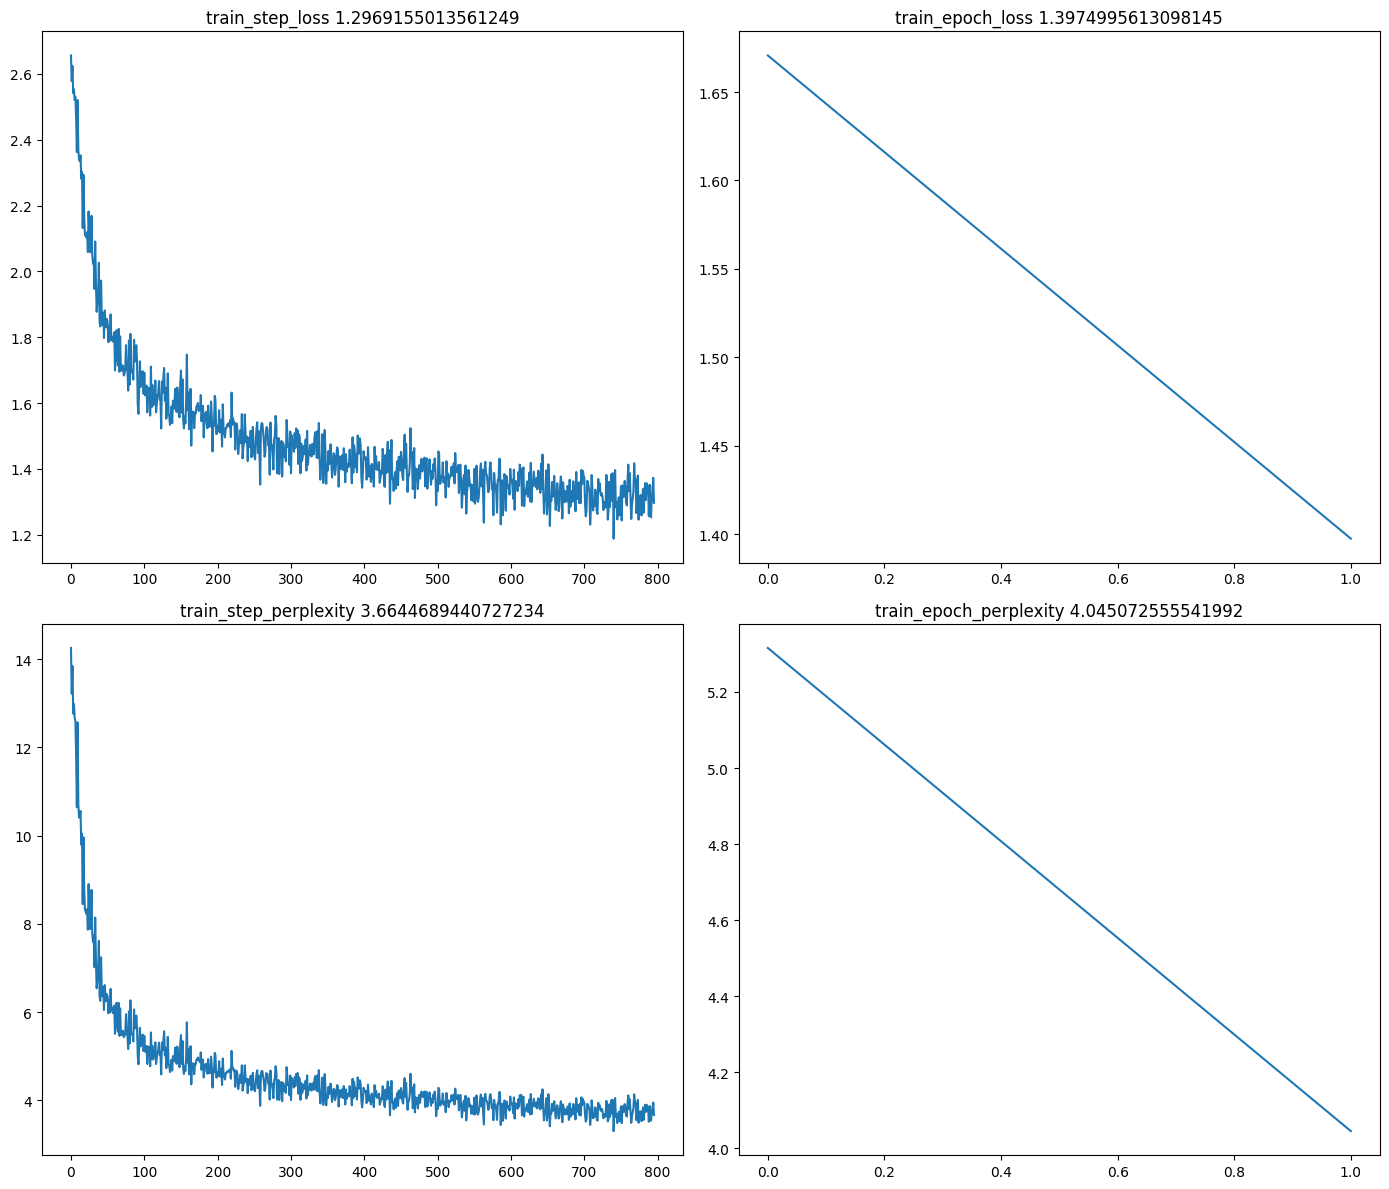

Training Epoch: 3/3, step 185/305 completed (loss: 1.358014702796936):  61%|██████▏   | 187/305 [05:02<03:09,  1.60s/it]

Training Epoch: 3/3, step 304/305 completed (loss: 1.3201574087142944): 100%|██████████| 305/305 [08:12<00:00,  1.61s/it]
Training Epoch: 3/3, step 304/305 completed (loss: 1.3307762145996094): 100%|██████████| 305/305 [08:12<00:00,  1.61s/it]
Training Epoch: 3/3, step 304/305 completed (loss: 1.1081926822662354): 100%|██████████| 305/305 [08:12<00:00,  1.61s/it]
Training Epoch: 3/3, step 304/305 completed (loss: 1.3163824081420898): 100%|██████████| 305/305 [08:12<00:00,  1.62s/it]


Max CUDA memory allocated was 11 GB
Max CUDA memory reserved was 11 GB
Peak active CUDA memory was 11 GB
CUDA Malloc retries : 0
CPU Total Peak Memory consumed during the train (max): 10 GB
we are about to save the PEFT modules
PEFT modules are saved in ./output directory
Epoch 3: train_perplexity=3.7166, train_epoch_loss=1.3128, epoch time 493.58159019400046s
Key: avg_train_prep, Value: 4.3590989112854
Key: avg_train_loss, Value: 1.460320274035136
Key: avg_epoch_time, Value: 493.26845016233347
Key: avg_checkpoint_time, Value: 3.8840213423330474
Key: metrics_filename, Value: ./output/metrics_data_0-2024-11-03_18-39-28.json


In [204]:
import matplotlib.pyplot as plt
import time
import os
import json
import numpy as np
from IPython.display import display, clear_output

def plot_metrics(data, metric_name, x_label, y_label, title, ax):
    x = range(len(data[f'{metric_name}']))
    y = data[f'{metric_name}']
    ax.plot(x, y)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

clear_output(wait=True)

all_data = []
metrics = []
for i, file in enumerate([f for f in os.listdir('./output') if f.endswith('.json') and 'metrics_data' in f]):
    data = json.load(open(f'./output/{file}'))
    all_data.append(data)
    for key in data.keys():
        if key not in metrics:
            metrics.append(key)

averages = {}

for i, metric in enumerate(metrics):
    averages[metric] = []
    for j in range(len(all_data[0][metric])):
        avg = np.mean([data[metric][j] for data in all_data])
        averages[metric].append(avg)
n = 0
for a in averages.values():
    if len(a) > 0:
        n += 1

# Calculate number of rows needed for 2 plots per row
num_rows = (n + 1) // 2  # Round up division to get enough rows

fig = plt.figure(figsize=(14, 6*num_rows))
i = 0
for metric in metrics:
    if len(averages[metric]) > 0:
        i += 1
        # Create subplot with 2 columns and calculated rows
        ax = fig.add_subplot(num_rows, 2, i)
        plot_metrics(averages, metric, '', '', metric + ' ' + str(averages[metric][-1]), ax)
    
plt.tight_layout()



In [138]:
import signal
if torchrun:
  os.killpg(os.getpgid(torchrun.pid), signal.SIGTERM)
  torchrun = None

W1103 17:39:17.727921 145732 torch/distributed/elastic/agent/server/api.py:704] Received Signals.SIGTERM death signal, shutting down workers
W1103 17:39:17.728768 145732 torch/distributed/elastic/multiprocessing/api.py:897] Sending process 145781 closing signal SIGTERM
W1103 17:39:17.729342 145732 torch/distributed/elastic/multiprocessing/api.py:897] Sending process 145782 closing signal SIGTERM
W1103 17:39:17.729825 145732 torch/distributed/elastic/multiprocessing/api.py:897] Sending process 145783 closing signal SIGTERM
W1103 17:39:17.730362 145732 torch/distributed/elastic/multiprocessing/api.py:897] Sending process 145784 closing signal SIGTERM


Traceback (most recent call last):
  File "/home/ec2-user/.venv/bin/torchrun", line 8, in <module>
    sys.exit(main())
  File "/home/ec2-user/.venv/lib64/python3.9/site-packages/torch/distributed/elastic/multiprocessing/errors/__init__.py", line 355, in wrapper
    return f(*args, **kwargs)
  File "/home/ec2-user/.venv/lib64/python3.9/site-packages/torch/distributed/run.py", line 919, in main
    run(args)
  File "/home/ec2-user/.venv/lib64/python3.9/site-packages/torch/distributed/run.py", line 910, in run
    elastic_launch(
  File "/home/ec2-user/.venv/lib64/python3.9/site-packages/torch/distributed/launcher/api.py", line 138, in __call__
    return launch_agent(self._config, self._entrypoint, list(args))
  File "/home/ec2-user/.venv/lib64/python3.9/site-packages/torch/distributed/launcher/api.py", line 260, in launch_agent
    result = agent.run()
  File "/home/ec2-user/.venv/lib64/python3.9/site-packages/torch/distributed/elastic/metrics/api.py", line 137, in wrapper
    result =

In [88]:
from transformers import AutoTokenizer

from llama_recipes.inference.model_utils import  load_llama_from_config
from llama_recipes.model_checkpointing import load_sharded_model_single_gpu
dist_checkpoint_root_folder = "/mnt/efs/checkpoints"

model_def = load_llama_from_config(model_name)
model = load_sharded_model_single_gpu(model_def, dist_checkpoint_root_folder + "/" + 'r2ai-3.2-1B-Instruct-meta-llama/Llama-3.2-1B-Instruct')
tokenizer = AutoTokenizer.from_pretrained(model_name)

save_path = dist_checkpoint_root_folder + "/" + 'hf/' + name
tokenizer.save_pretrained(save_path)
hf_model_path = model.save_pretrained(save_path)
print(f"HuggingFace model checkpoints has been saved in {hf_model_path}")


/opt/conda/envs/pytorch/lib/python3.11/site-packages/llama_recipes/model_checkpointing/checkpoint_handler.py:259: FutureWarning: `load_state_dict` is deprecated and will be removed in future versions. Please use `load` instead.
  dist_cp.load_state_dict(


Sharded state checkpoint loaded from /mnt/efs/checkpoints/r2ai-3.2-1B-Instruct-meta-llama/Llama-3.2-1B-Instruct
HuggingFace model checkpoints has been saved in None


In [174]:
from datasets import load_dataset
dataset = load_dataset('csv', data_files='radare2_ok.tsv', split='train', sep='\t')
print(dataset[0])
eval_messages = [
  [{"role": "user", "content": "What is the capital of France?"}]
]
for d in dataset:
  eval_messages.append([
    {"role": "system", "content": "You are an expert reverse engineer, proficient in radare2."},
    {"role": "user", "content": d['q']}
  ])



{'q': "I think there's a jump table in this function. How can I find its location?", 'a': 'CCf~cases'}


In [207]:
from llama_recipes.inference.model_utils import load_model
import torch
from dataclasses import asdict
from peft import PeftModel, LoraConfig
hf_model_path = dist_checkpoint_root_folder + "/" + 'hf/' + name
if IS_LORA:
  model = load_model(model_name, None, True)
  tokenizer = AutoTokenizer.from_pretrained(model_name)
else:
  model = load_model(hf_model_path, None, True)
  tokenizer = AutoTokenizer.from_pretrained(hf_model_path)
tokenizer.pad_token = tokenizer.eos_token
model.generation_config.pad_token_id = tokenizer.pad_token_id
if IS_LORA:
  model = PeftModel.from_pretrained(model, output_dir)
import random
#shuffle eval_messages
random.shuffle(eval_messages)

for messages in eval_messages[:10]:
  print()
  print(messages[-1]['content'])
  prompt_tokens = tokenizer.apply_chat_template(messages)
  prompt_tokens = torch.tensor(prompt_tokens).long()
  prompt_tokens = prompt_tokens.unsqueeze(0).to("cuda")
  attention_mask = torch.ones_like(prompt_tokens)
  output = model.generate(input_ids=prompt_tokens, attention_mask=attention_mask, max_new_tokens=500, use_cache=False, do_sample=True) 
  print(tokenizer.decode(output[0][len(prompt_tokens[0]):], skip_special_tokens=True).replace('assistant', '').strip())
  



use_fast_kernelsTrue


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



How can I rename a flag from 'flag.old' to 'flag.new'?
```
fr flag.new flag.old
```

Set the calling convention of the `add` function to `cdecl`.
```
afcs cdecl @ sym.add
```

How can I remove all breakpoints in the debugger?
?

```
db-
```

How can I disassemble the function at address 0x401000?
```
pdf @ 0x401000
```

Visualize the call graph in an interactive ASCII art view.
This command will display the call graph in a format that is easy to read and understand, with each branch represented by a line in ASCII art.

```
agc
```

Show code locations, relationing source-line with address
.

```
CCF
```

Find all functions calling `system`
’

```
axt @f:system
```

List functions calling imports that interact with the console, like printing text or reading from stdin
This command lists all functions that call imports that interact with the console, such as printing text or reading from stdin.

```
ahm
```

How do I list all imported libraries?
```
iil
```

Temporal seek to the program

In [118]:
# TODO: fix the notebook PATH env so we can put llama.cpp build here
#!python ./llama.cpp/convert_hf_to_gguf.py {hf_model_path} --outtype f16 --outfile {hf_model_path}.fp16.gguf
q_method = "Q4_K_M"
q_path = f"{hf_model_path}.{q_method}.gguf"
!./llama.cpp/llama-quantize {hf_model_path}.fp16.gguf {q_path} {q_method}
q_path


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


main: build = 3998 (0a683e80)
main: built with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
main: quantizing '/mnt/efs/checkpoints/hf/r2ai-3.2-1B-Instruct.fp16.gguf' to '/mnt/efs/checkpoints/hf/r2ai-3.2-1B-Instruct.Q4_K_M.gguf' as Q4_K_M
llama_model_loader: loaded meta data with 28 key-value pairs and 147 tensors from /mnt/efs/checkpoints/hf/r2ai-3.2-1B-Instruct.fp16.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = R2Ai 3.2 1B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = Instruct
llama_model_loader: - kv   4:                           general.basename 

'/mnt/efs/checkpoints/hf/r2ai-3.2-1B-Instruct.Q4_K_M.gguf'

In [135]:
for messages in eval_messages[:3]:
  prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  !./llama.cpp/llama-cli -lv 0 --model {q_path} --prompt "{prompt}"



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 4 CUDA devices:
  Device 0: NVIDIA A10G, compute capability 8.6, VMM: yes
  Device 1: NVIDIA A10G, compute capability 8.6, VMM: yes
  Device 2: NVIDIA A10G, compute capability 8.6, VMM: yes
  Device 3: NVIDIA A10G, compute capability 8.6, VMM: yes
build: 3998 (0a683e80) with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
main: llama backend init
main: load the model and apply lora adapter, if any
llama_load_model_from_file: using device CUDA0 (NVIDIA A10G) - 18975 MiB free
llama_load_model_from_file: using device CUDA1 (NVIDIA A10G) - 18663 MiB free
llama_load_model_from_file: using device CUDA2 (NVIDIA A10G) - 18663 MiB free
llama_load_model_from_file: using device CUDA3 (NVIDIA A10G) - 21993 MiB free
llama_model_loader: loaded meta data with 28 key-value pairs and 147 tensors from /mnt/efs/checkpoints/hf/r2ai-3.2-1B-Instruct.Q4_K_M.gguf (version GGUF V3 (latest))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 4 CUDA devices:
  Device 0: NVIDIA A10G, compute capability 8.6, VMM: yes
  Device 1: NVIDIA A10G, compute capability 8.6, VMM: yes
  Device 2: NVIDIA A10G, compute capability 8.6, VMM: yes
  Device 3: NVIDIA A10G, compute capability 8.6, VMM: yes
build: 3998 (0a683e80) with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
main: llama backend init
main: load the model and apply lora adapter, if any
llama_load_model_from_file: using device CUDA0 (NVIDIA A10G) - 18975 MiB free
llama_load_model_from_file: using device CUDA1 (NVIDIA A10G) - 18663 MiB free
llama_load_model_from_file: using device CUDA2 (NVIDIA A10G) - 18663 MiB free
llama_load_model_from_file: using device CUDA3 (NVIDIA A10G) - 21993 MiB free
llama_model_loader: loaded meta data with 28 key-value pairs and 147 tensors from /mnt/efs/checkpoints/hf/r2ai-3.2-1B-Instruct.Q4_K_M.gguf (version GGUF V3 (latest))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 4 CUDA devices:
  Device 0: NVIDIA A10G, compute capability 8.6, VMM: yes
  Device 1: NVIDIA A10G, compute capability 8.6, VMM: yes
  Device 2: NVIDIA A10G, compute capability 8.6, VMM: yes
  Device 3: NVIDIA A10G, compute capability 8.6, VMM: yes
build: 3998 (0a683e80) with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
main: llama backend init
main: load the model and apply lora adapter, if any
llama_load_model_from_file: using device CUDA0 (NVIDIA A10G) - 18975 MiB free
llama_load_model_from_file: using device CUDA1 (NVIDIA A10G) - 18663 MiB free
llama_load_model_from_file: using device CUDA2 (NVIDIA A10G) - 18663 MiB free
llama_load_model_from_file: using device CUDA3 (NVIDIA A10G) - 21993 MiB free
llama_model_loader: loaded meta data with 28 key-value pairs and 147 tensors from /mnt/efs/checkpoints/hf/r2ai-3.2-1B-Instruct.Q4_K_M.gguf (version GGUF V3 (latest))

In [122]:
import huggingface_hub
# huggingface_hub.interpreter_login()
hf_username = huggingface_hub.whoami()['name']
repo_id = f"{hf_username}/{name}-GGUF"
huggingface_hub.create_repo(repo_id=repo_id)
huggingface_hub.upload_file(path_or_fileobj=q_path, path_in_repo=f"{name}.{q_method}.gguf", repo_id=repo_id)


r2ai-3.2-1B-Instruct.Q4_K_M.gguf:   0%|          | 0.00/808M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dnakov/r2ai-3.2-1B-Instruct-GGUF/commit/1038889bdf85e9c590d85b95ef2f3cb17d027149', commit_message='Upload r2ai-3.2-1B-Instruct.Q4_K_M.gguf with huggingface_hub', commit_description='', oid='1038889bdf85e9c590d85b95ef2f3cb17d027149', pr_url=None, repo_url=RepoUrl('https://huggingface.co/dnakov/r2ai-3.2-1B-Instruct-GGUF', endpoint='https://huggingface.co', repo_type='model', repo_id='dnakov/r2ai-3.2-1B-Instruct-GGUF'), pr_revision=None, pr_num=None)